In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_csv("cs-training.csv")
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
plt.figure(figsize=(20,20),dpi=400)
ax=sns.heatmap(data.corr(),annot=True)

In [6]:
#missing Values

<AxesSubplot:>

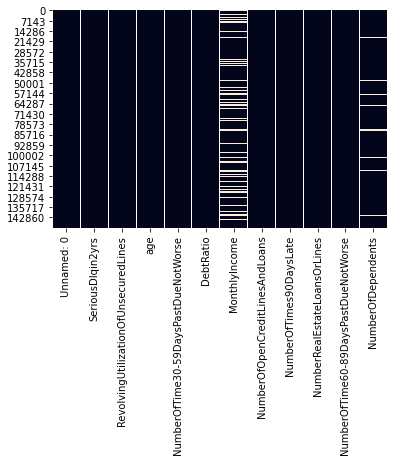

In [7]:
sns.heatmap(data.isnull(),cbar=False)

In [8]:
data=data.fillna(data.mean())
data=data.drop(columns=["Unnamed: 0"])
data.shape

(150000, 11)

Positive :  10026
Negative :  139974


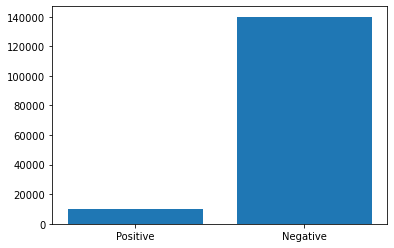

In [9]:
#Check imbalanced dataset
pos=data[data["SeriousDlqin2yrs"]==1]
neg=data[data["SeriousDlqin2yrs"]==0]
positive=len(pos)
negative=len(neg)
count=[positive,negative]
labels=["Positive","Negative"]
print("Positive : ",positive)
print("Negative : ",negative)
plt.bar(labels,count)
plt.show()

In [10]:
pos=data[data["SeriousDlqin2yrs"]==1]
neg=data[data["SeriousDlqin2yrs"]==0]
neg=neg.sample(frac=1)[0:10026]
print("Positive Size: ",len(pos))
print("Negative Size: ", len(neg))
dataset = [pos[:],neg[:]]
dataset = pd.concat(dataset)
print("Dataset Size : ",len(dataset))

Positive Size:  10026
Negative Size:  10026
Dataset Size :  20052


In [11]:
# Check Outliers
lf=LocalOutlierFactor()
pred=lf.fit_predict(dataset)
dataset=dataset[pred==1]
dataset.shape

(19028, 11)

In [12]:
len(pred) , len(pred[pred == 1] ) ,len(pred[pred == -1])

(20052, 19028, 1024)

In [13]:
dataset["SeriousDlqin2yrs"].value_counts()

0    9553
1    9475
Name: SeriousDlqin2yrs, dtype: int64

In [14]:
dataset.nunique()

SeriousDlqin2yrs                            2
RevolvingUtilizationOfUnsecuredLines    15521
age                                        77
NumberOfTime30-59DaysPastDueNotWorse       16
DebtRatio                               16980
MonthlyIncome                            4651
NumberOfOpenCreditLinesAndLoans            41
NumberOfTimes90DaysLate                    17
NumberRealEstateLoansOrLines               18
NumberOfTime60-89DaysPastDueNotWorse       11
NumberOfDependents                         11
dtype: int64

In [15]:
x = dataset
minmax = MinMaxScaler(feature_range=(0,1))
std = StandardScaler()
tempCol = ["age","RevolvingUtilizationOfUnsecuredLines","DebtRatio"]
for _ in tempCol:
    x[_] = x[_].astype(int)
    x[_] = minmax.fit_transform(x[[_]])

In [37]:
inputs = dataset[["RevolvingUtilizationOfUnsecuredLines","age","NumberOfTime30-59DaysPastDueNotWorse"]]
outputs = dataset["SeriousDlqin2yrs"]
inputs.shape,outputs.shape

((19028, 3), (19028,))

In [38]:
x.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [39]:
#Train test split
X_train,X_test,Y_train,Y_test= train_test_split(inputs,outputs,test_size=0.10)
X_train.shape , Y_train.shape

((17125, 3), (17125,))

In [40]:
#Models

In [41]:
#XGBOOST

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
params =  {
    'clf__max_depth' : np.arange(4,10,1),
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__n_estimators' : np.arange(100,200,400),
    'clf__subsample': np.arange(0.5,1,0.1),
    'clf__scale_pos_weight': [10,15,20]
    
}
clf = RandomizedSearchCV(estimator=XGBClassifier(),
                         param_distributions=params,
                         scoring='roc_auc',
                         n_iter=20,
                         verbose=0)
clf.fit(X_train, Y_train)

print("Best parameters:", clf.best_params_)
print("Best score: ", clf.best_score_)

[15:19:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

[15:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

[15:19:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

[15:19:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

[15:19:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

[15:19:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:19:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "clf__scale_pos_weight", "clf__subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find 

In [22]:
#Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,Y_train)
model.score(X_test,Y_test)

0.6868102995270625

In [34]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [24]:
from sklearn.model_selection import GridSearchCV
params = {"max_features" : [2,3,4,5,6,7],
          "max_samples"  : list(range(0,50,5))
         }
search = GridSearchCV(RandomForestClassifier(),param_grid=params)
search.fit(X_train,Y_train)
search.best_score_

0.6945985401459854

In [25]:
#KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

params = {"n_neighbors" : [2,3,4,5,6,7]
         }
search = GridSearchCV(KNeighborsClassifier(),param_grid=params)
search.fit(X_train,Y_train)
print(search.score(X_test,Y_test))
search.best_score_

0.6594850236468733


0.6692554744525547

In [27]:
#Sequential

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import  tensorflow.keras.optimizers 
import tensorflow.keras.losses
import tensorflow.keras.metrics

inputs_shape = X_train.shape[1]
model=Sequential()
model.add(Dense(256,activation="relu",input_dim=inputs_shape))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(3,activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",#"categorical_crossentropy",
                   optimizer="adam",
                   metrics=['accuracy'])
history = model.fit(
                    X_train,
                    Y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_test, Y_test),
            )


Epoch 1/25
34/34 [==============================] - 2s 25ms/step - loss: 0.8119 - accuracy: 0.6586 - val_loss: 0.6007 - val_accuracy: 0.6889
Epoch 2/25
34/34 [==============================] - 0s 12ms/step - loss: 0.5978 - accuracy: 0.6854 - val_loss: 0.5871 - val_accuracy: 0.6942
Epoch 3/25
34/34 [==============================] - 0s 13ms/step - loss: 0.5887 - accuracy: 0.6891 - val_loss: 0.5823 - val_accuracy: 0.6963
Epoch 4/25
34/34 [==============================] - 0s 12ms/step - loss: 0.5883 - accuracy: 0.6886 - val_loss: 0.5963 - val_accuracy: 0.6768
Epoch 5/25
34/34 [==============================] - 0s 13ms/step - loss: 0.5862 - accuracy: 0.6910 - val_loss: 0.5854 - val_accuracy: 0.6947
Epoch 6/25
34/34 [==============================] - 0s 12ms/step - loss: 0.5851 - accuracy: 0.6899 - val_loss: 0.5787 - val_accuracy: 0.6957
Epoch 7/25
34/34 [==============================] - 0s 12ms/step - loss: 0.5847 - accuracy: 0.6916 - val_loss: 0.5822 - val_accuracy: 0.6942
Epoch 8/25
34